Task: Once we have accurately calculated the expected returns and volatility of the ETFs, we want to find a way to best invest amongst the different ETFs. Below, we show the data of some of the ETFs we have in our fund. ___How would you decide to allocate amongst these funds?___


Files:
1. asset_classes.csv
2. covariance_matrix.csv
3. asset_class_currency_exposure.csv


In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (14, 8)
# plt.style.use('seaborn-dark')

Portfolio allocation is an optimization problem. One strategy is the modern portfolio theory.

## MPT

First, we import our available assets and perform some data cleaning.

     ticker  return      sd  div_yield  expense_ratio
0    IVV US  0.0552  0.1630     0.0198         0.0003
1    VGK US  0.0686  0.1542     0.0226         0.0008
2   AAXJ US  0.0384  0.1758     0.0254         0.0068
3    EWA US  0.0697  0.1460     0.0403         0.0050
4    EWC US  0.0295  0.1781     0.0264         0.0049
5    EWJ US -0.0089  0.2269     0.0242         0.0049
6   SPEM US  0.0540  0.2240     0.0385         0.0011
7    BIL US  0.0152  0.0011     0.0205         0.0014
8    SHY US  0.0195  0.0130     0.0194         0.0015
9   SCHR US  0.0183  0.0453     0.0212         0.0005
10   VNQ US  0.0618  0.2293     0.0413         0.0012
11  VNQI US  0.0103  0.2489     0.0758         0.0012
12   GLD US  0.0481  0.1291     0.0000         0.0040


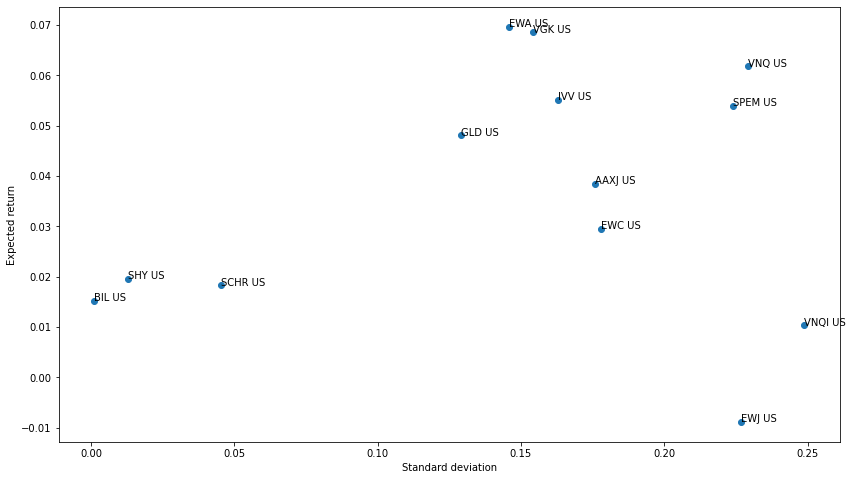

In [15]:
ast = pd.read_csv('csv/asset_classes.csv', sep='\t') # tab separated


#rename
ast.columns = ['asset', 'ticker', 'return', 'sd', 'div_yield', 'expense_ratio']

# clean up ticker
# ast['ticker'] = ast['ticker'].replace(' ', '_', regex=True)

# convert % string to float
ast['return'] 		 = ast['return'].replace('%','',regex=True).astype('float')/100
ast['sd'] 			 = ast['sd'].replace('%','',regex=True).astype('float')/100
ast['div_yield'] 	 = ast['div_yield'].replace('%','',regex=True).astype('float')/100
ast['expense_ratio'] = ast['expense_ratio'].replace('%','',regex=True).astype('float')/100

# drop column 'asset'
ast = ast.drop(columns=['asset'])
plt.scatter(ast['sd'], ast['return'])
plt.xlabel('Standard deviation')
plt.ylabel('Expected return')

# annotate label 
for i, txt in enumerate(ast['ticker']):
    plt.annotate(txt, (ast['sd'][i], ast['return'][i]))

print(ast)

Then the covariance matrix.

In [16]:
cov_matrix = pd.read_csv('csv/covariance_matrix.csv', index_col=[0])

for column in cov_matrix.columns :
    cov_matrix[column] = cov_matrix[column].replace('%','',regex=True).astype('float')/100
    
print(cov_matrix)

         IVV US  VGK US  AAXJ US  EWA US  EWC US  EWJ US  SPEM US  BIL US  \
IVV US    0.027   0.021    0.021   0.016   0.020   0.023    0.026     0.0   
VGK US    0.021   0.024    0.021   0.019   0.023   0.028    0.027     0.0   
AAXJ US   0.021   0.021    0.031   0.021   0.025   0.022    0.038     0.0   
EWA US    0.016   0.019    0.021   0.021   0.017   0.022    0.028     0.0   
EWC US    0.020   0.023    0.025   0.017   0.032   0.024    0.035     0.0   
EWJ US    0.023   0.028    0.022   0.022   0.024   0.051    0.025     0.0   
SPEM US   0.026   0.027    0.038   0.028   0.035   0.025    0.050     0.0   
BIL US    0.000   0.000    0.000   0.000   0.000   0.000    0.000     0.0   
SHY US   -0.001  -0.001    0.000   0.000   0.000  -0.002    0.000     0.0   
SCHR US  -0.004  -0.004   -0.003  -0.003  -0.004  -0.007   -0.003     0.0   
VNQ US    0.020   0.026    0.023   0.021   0.021   0.018    0.032     0.0   
VNQI US   0.032   0.035    0.035   0.032   0.035   0.043    0.045     0.0   

### Simulate portfolios + plot efficient frontier

Simulate n=500 portfolios by varying the weight of each of the 13 assets. For each portfolio, calculate

1. expected return 
2. s.d. (using the covariance matrix file provided)
3. sharpe ratio

In [17]:
USD_cor = [97.5,
0.2,
0.1,
0.0,
0.5,
0.0,
0.1,
100.0,
90.8,
99.2,
99.9,
0.2,
-126.6,]

ast['usd_cor'] = USD_cor
ast['usd_cor'] = ast['usd_cor'].astype('float')/100

In [18]:
port_num  = 1000
asset_num = len(ast['ticker'])
np.random.seed(123)

port_weight = np.zeros((port_num, asset_num)) 
port_return = np.zeros(port_num)
port_sd     = np.zeros(port_num)
port_sharpe = np.zeros(port_num)
port_usd_cor = np.zeros(port_num)

for n in range(port_num):
    weights = np.array(np.random.random(asset_num))
    weights = weights/np.sum(weights) # ensure sum of weights = 1
    
    port_weight[n,:] = weights
    
    port_return[n] = np.sum(ast['return'] * weights)
    port_sd[n]     = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    port_sharpe[n] = port_return[n]/port_sd[n]
    
    port_usd_cor[n] = np.sum(ast['usd_cor'] * weights)

We plot our available portfolios together with individual assets. 

Identify our optimal porfolio (greatest sharpe ratio) with a red x. For the same level of risk (standard deviation), there is no other possible combination with a higher return.

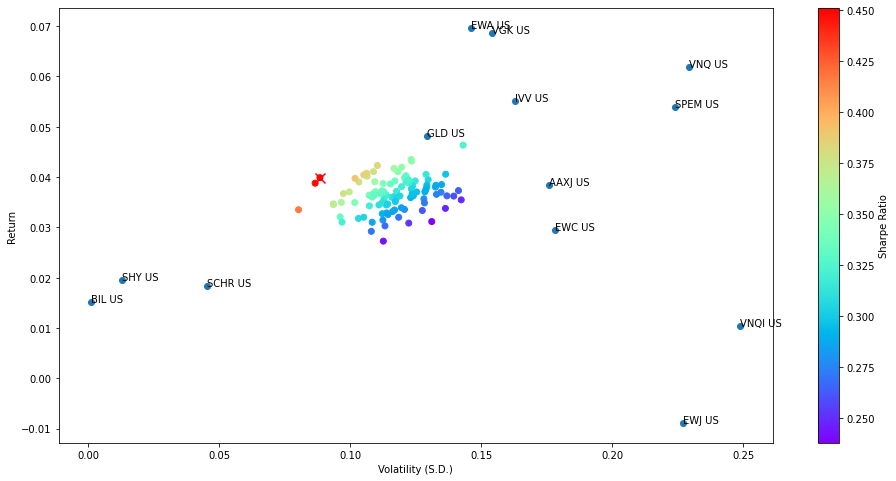

In [31]:
plt.figure(figsize=(16, 8))
plt.scatter(ast['sd'], ast['return']) # Individual assets
for i, txt in enumerate(ast['ticker']):
    plt.annotate(txt, (ast['sd'][i], ast['return'][i]))
    
plt.scatter(port_sd, port_return, c=port_sharpe, cmap='rainbow') # Portfolios
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Volatility (S.D.)')
plt.ylabel('Return')

optimal_portfolio = {
    "return": port_return[port_sharpe.argmax()],
    "sd": port_sd[port_sharpe.argmax()],
    "sharpe": port_sharpe.max(),
    'weight': port_weight[port_sharpe.argmax()],
    "usd_cor": port_usd_cor[port_sharpe.argmax()]
}

plt.scatter(port_sd[port_sharpe.argmax()], port_return[port_sharpe.argmax()],c='red', marker='x', s=100) # red dot

Optimal asset allocation according to MPT:

In [20]:
results = pd.DataFrame({'ticker': ast['ticker'], 'weights (%)': optimal_portfolio['weight'] * 100})

print(results.round(2))

print('Expected return', (optimal_portfolio['return']*100).round(2), '%')
print('Volatility', (optimal_portfolio['sd']*100).round(2), '%')
print('Sharpe ratio', (optimal_portfolio['sharpe']*100).round(2))
print('USD cor', (optimal_portfolio['usd_cor']*100).round(2))

     ticker  weights (%)
0    IVV US         7.71
1    VGK US        14.14
2   AAXJ US         5.12
3    EWA US         8.24
4    EWC US         8.14
5    EWJ US         0.33
6   SPEM US         0.53
7    BIL US         3.56
8    SHY US        13.93
9   SCHR US        13.53
10   VNQ US         9.52
11  VNQI US         1.00
12   GLD US        14.25
Expected return 4.29 %
Volatility 8.47 %
Sharpe ratio 50.62
USD cor 28.69


---

Task: Suppose now that the client believes the USD is likely to depreciate and hence wants to reduce his exposure to the currency. ___How would you design a portfolio that fulfills his requirements?___

We choose assets that have the least correlation with USD.

{'return': 0.04316684102456792, 'sd': 0.12338976602010548, 'sharpe': 0.34984133949596913, 'weight': array([0.16871117, 0.04035959, 0.1563948 , 0.15666178, 0.01557348,
       0.07909066, 0.08566891, 0.05350618, 0.00807526, 0.04122714,
       0.01629561, 0.04064107, 0.13779436]), 'usd_cor': 0.10854280641272043}
     ticker  weights (%)
0    IVV US        16.87
1    VGK US         4.04
2   AAXJ US        15.64
3    EWA US        15.67
4    EWC US         1.56
5    EWJ US         7.91
6   SPEM US         8.57
7    BIL US         5.35
8    SHY US         0.81
9   SCHR US         4.12
10   VNQ US         1.63
11  VNQI US         4.06
12   GLD US        13.78
Expected return 4.32 %
Volatility 12.34 %
Sharpe ratio 34.98
USD cor 10.85
[0.28535173 0.36849058 0.13019631 0.29414571 0.24112967 0.32282453
 0.12179625 0.42658535 0.18626137 0.35766641 0.12489654 0.29267325
 0.18400355 0.245946   0.31804029 0.41015856 0.31732597 0.10854281
 0.22312758 0.38599811 0.44122705 0.24420835 0.40325361 0.25481

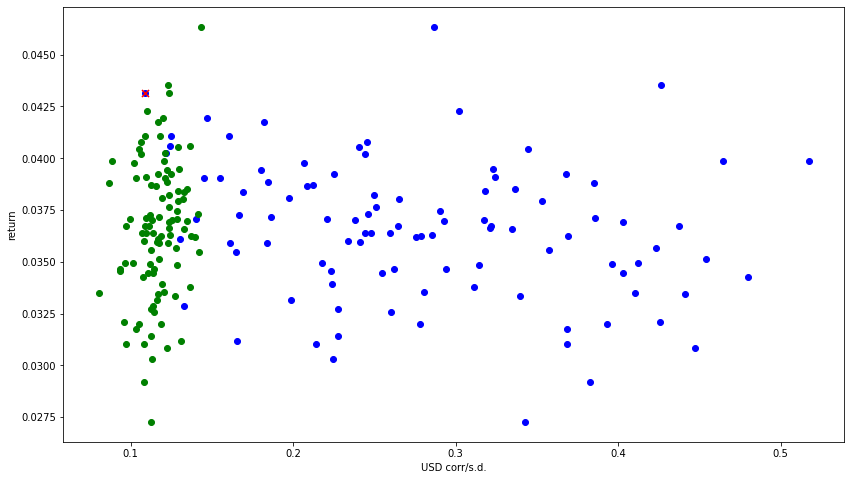

In [29]:



port_num  = 100
asset_num = len(ast['ticker'])
np.random.seed(123)

port_weight = np.zeros((port_num, asset_num)) 
port_return = np.zeros(port_num)
port_sd     = np.zeros(port_num)
port_sharpe = np.zeros(port_num)
port_usd_cor = np.zeros(port_num)

for n in range(port_num):
    weights = np.array(np.random.random(asset_num))
    weights = weights/np.sum(weights) # ensure sum of weights = 1
    
    port_weight[n,:] = weights
    
    port_return[n] = np.sum(ast['return'] * weights)
    port_sd[n]     = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    port_sharpe[n] = port_return[n]/port_sd[n]
    port_usd_cor[n] = np.sum(ast['usd_cor'] * weights)
    

port_max = port_usd_cor.argmin()


plt.scatter(port_usd_cor, port_return, c='blue') # Portfolios
plt.scatter(port_sd, port_return, c='green') # Portfolios


plt.xlabel('USD corr/s.d.')
plt.ylabel('return')

optimal_portfolio = {
    "return": port_return[port_max],
    "sd": port_sd[port_max],
    "sharpe": port_sharpe[port_max],
    'weight': port_weight[port_max],
    "usd_cor": port_usd_cor.min()
}

plt.scatter(port_usd_cor[port_max], port_return[port_max],c='red', marker='x', s=50) # red dot


print(optimal_portfolio)
results = pd.DataFrame({'ticker': ast['ticker'], 'weights (%)': optimal_portfolio['weight'] * 100})

print(results.round(2))

print('Expected return', (optimal_portfolio['return']*100).round(2), '%')
print('Volatility', (optimal_portfolio['sd']*100).round(2), '%')
print('Sharpe ratio', (optimal_portfolio['sharpe']*100).round(2))
print('USD cor', (optimal_portfolio['usd_cor']*100).round(2))

print(port_usd_cor)


---

## References

1. https://www.youtube.com/watch?v=KDw3hC2YNFc
1. https://towardsdatascience.com/automating-portfolio-optimization-using-python-9f344b9380b9
1. https://towardsdatascience.com/efficient-frontier-portfolio-optimisation-in-python-e7844051e7f
